# Exercise 8: Filtering

https://docs.opencv.org/4.5.1/d4/d13/tutorial_py_filtering.html  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

https://docs.opencv.org/4.5.1/d5/d0f/tutorial_py_gradients.html  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html

https://docs.opencv.org/4.5.1/de/dbc/tutorial_py_fourier_transform.html  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html#fourier-transform

In this exercise you will learn about:
- 2D convolutions.
- Various filters that can be convolved with an image using the `cv.filter2D()` function.
- The OpenCV functions `cv.blur()`, `cv.GaussianBlur()`, `cv.medianBlur()` and `cv.bilateralFilter()` for smoothing images.
- The OpenCV functions `cv.Sobel()`, `cv.Scharr()` and `cv.Laplacian()` for finding edges (gradients) in images.
- Numpy functions `np.fft.fft2()`, `np.fft.fftshift()`, `np.fft.ifft2()` and `np.fft.ifftshift()` for Fourier Transforms.
- OpenCV functions `cv.dft()`, `cv.idft()` and `cv.getOptimalDFTSize()` for Fourier Transforms.

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## 2D Convolutions (Image Filtering)

<p>

As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc. LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.

OpenCV provides a function `cv.filter2D()` to convolve a kernel (filter) $K$ with an image. As a first example, we will try an averaging filter on an image. A 5x5 averaging filter kernel will look as below:

$$
K = \frac{1}{25}

\begin{bmatrix}
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1
\end{bmatrix}
$$

The convolution operation works like this. For each pixel in the image:

1. Center the kernel on the pixel.
2. Create the weighted sum of each pixel under the kernel, i.e. multiply each pixel under kernel with the corresponding kernel value, i.e. $\frac{1}{25}$ in this case, and sum them all together, which calculates the average pixel value in this case.
3. Replace the center pixel value with the computed average.

<img width="450" height="225" src="../notebook_images/conv_padding2.gif" style="padding: 10px; float: right;">

When we flip the kernel (filter) both vertically and horizontally, then slide the flipped kernel (filter) over the entire image, applying steps 1-3 above, we are *convolving* the kernel (filter) with the image. This is the definition of a 2D  convolution. But, kernels (filters) aren't actually flipped when applied to images. Therefore, we are actually applying 2D cross-correlations, not 2D convolutions, but we will still use the term convolution (incorrectly, as everyone else does).

Normally we would also *zero-pad* the image (i.e. add rows and columns of zeros around the image) before convolving the image, so that the convolved image has the same size as the original image. Convolving a kernel with a zero-padded image is shown in the figure to the right. Notice that this kernel looks like this:

$$
K =
\begin{bmatrix}
0 & -1 & 0\\
-1 & 5 & -1\\
0 & -1 & 0
\end{bmatrix}
$$

Therefore, the colvolution of the kernel (filter) centered over the image's first pixel (top left pixel with a value of 60) is calculated as (notice the [hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) $\odot$):

$$

\sum_{ij} \left(

\begin{bmatrix}
0 & -1 & 0\\
-1 & 5 & -1\\
0 & -1 & 0
\end{bmatrix}

\odot

\begin{bmatrix}
0 & 0 & 0\\
0 & 60 & 113\\
0 & 73 & 121
\end{bmatrix}

\right)

=

\sum_{ij} \left(

\begin{bmatrix}
0*0 & -1*0 & 0*0\\
-1*0 & 5*60 & -1*113\\
0*0 & -1*73 & 0*121
\end{bmatrix}

\right)

= 5*60 + (-1)*113 + (-1)*73

= 114

$$
</p>

---

Let's implement our own convolution function so we know how it works, before using OpenCV's `cv.filter2D()` function.

In [2]:
# The convolve function:
# - flips the kernel (filter)
# - zero pads the image
# - centers the kernel on each pixel in the image
# - computes the weighted sum of the kernel and image patch
def convolve(image, kernel, flip_kernel=False):    
    K = kernel.copy()
    if flip_kernel:
        K = np.flip(kernel)
    padding = kernel.shape[0] // 2
    I = np.pad(image, (padding,), 'constant', constant_values=(0,))
    img_convolved = np.zeros(image.shape)

    n_rows, n_cols = I.shape
    for row in range(padding, n_rows-padding):
        for col in range(padding, n_cols-padding):
            img_convolved[row-padding, col-padding] = np.sum(K * I[row-padding:row+padding+1, col-padding:col+padding+1])

    return img_convolved

# Let's create the same image as the example in the text above
image = np.array([
    [ 60, 113,  56, 139,  85],
    [ 73, 121,  54,  84, 128],
    [131,  99,  70, 129, 127],
    [ 80,  57, 115,  69, 134],
    [104, 126, 123,  95, 130],
], dtype=np.float32)

# Let's create the same kernel as the example in the text above
kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

# Now, let's use convolve function to convolve the kernel over the image
result = convolve(image, kernel)

# We get the same result as the example in the text above
result

array([[ 114.,  328.,  -26.,  470.,  158.],
       [  53.,  266.,  -61.,  -30.,  344.],
       [ 403.,  116.,  -47.,  295.,  244.],
       [ 108., -135.,  256., -128.,  344.],
       [ 314.,  346.,  279.,  153.,  421.]])

Lets try the same kernel and image with OpenCV's built-in function `cv.filter2D()`.

`filter2D(src, ddepth, kernel[, dst[, anchor[, delta[, borderType]]]]) -> dst`
- `src` is the input image.
- `ddepth` is the pixel depth of the destination image (if set to `-1`, the destination image depth = source image depth).
- `kernel` is the filter kernel.
- `borderType` is the type of padding we want to use (`cv.BORDER_CONSTANT` gives us zero padding).

The function returns the convolved image. See [this link](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04) for more information about the `cv.filter2D()` function.

In [3]:
# Use OpenCV's 'filter2D()' function with the same image, kernel and zero padding
dst = cv.filter2D(image, -1, kernel, borderType=cv.BORDER_CONSTANT)

# Did we get the same result using OpenCV's function and our own implementation?
print(f"OpenCV's function and our implementation yielded the same result: {np.all(result == dst)}")

OpenCV's function and our implementation yielded the same result: True


Let's try the averaging kernel from the text above with another image.

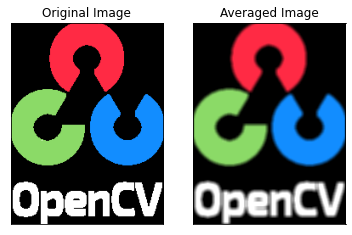

In [4]:
# Read in the OpenCV logo
img = cv.imread('../data/opencv-logo-white.png')

# Define the averaging kernel
kernel = np.ones((5,5), np.float32) / 25

# Filter the image (the kernel is convolved with each color channel separately)
dst = cv.filter2D(img, -1, kernel, borderType=cv.BORDER_CONSTANT)

# Plot the original and averaged image
plt.subplot(121), plt.imshow(img[:,:,::-1]), plt.title('Original Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(dst[:,:,::-1]), plt.title('Averaged Image')
plt.xticks([]), plt.yticks([])
plt.show()

## Image Blurring (Image Smoothing)

Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noise. It actually removes high frequency content (eg: noise, edges) from the image. So edges are blurred a little bit in this operation (there are also blurring techniques which don't blur the edges). OpenCV provides four main types of blurring techniques.

### 1. Averaging

This is done by convolving an image with a normalized box filter. It simply takes the average of all the pixels under the kernel area and replaces the central element's value with the average. This is done by the function [cv.blur()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37) or [cv.boxFilter()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gad533230ebf2d42509547d514f7d3fbc3). Check the OpenCv documentation for more details.

`cv.blur(src, ksize[, dst[, anchor[, borderType]]]) -> dst`

`cv.boxFilter(src, ddepth, ksize[, dst[, anchor[, normalize[, borderType]]]]) -> dst`

We should, at least specify the image `src`, and the width and height of the kernel `ksize`. A 3x3 normalized box filter would look like the below:

$$
K = \frac{1}{9}

\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix}
$$

If you don't want to use a normalized box filter, use `cv.boxFilter()`. Pass an argument `normalize=False` to the function.

Let's look at an example with a kernel size of 5x5 using the `cv.blur()` function:

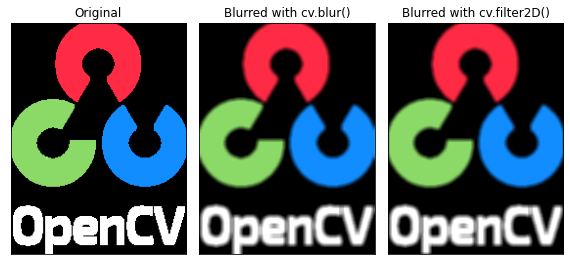

In [5]:
# Read in the OpenCv logo
img = cv.imread('../data/opencv-logo-white.png')

# Blur the image with a 5x5 kernel
blur = cv.blur(img, (5,5))

# We can also do this using the cv.filter2D() function with a custom averaging filter
kernel = np.ones((5,5), np.float32) / 25
dst = cv.filter2D(img, -1, kernel, borderType=cv.BORDER_CONSTANT)

# Plot the original and averaged image
plt.figure(figsize=(8,6))
plt.subplot(131),plt.imshow(img[:,:,::-1]),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(blur[:,:,::-1]),plt.title('Blurred with cv.blur()')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst[:,:,::-1]),plt.title('Blurred with cv.filter2D()')
plt.xticks([]), plt.yticks([])
plt.tight_layout(pad=1.0)
plt.show()

### 2. Gaussian Blurring

In this method, instead of a box filter, a Gaussian kernel is used. It is done with the function, [cv.GaussianBlur()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1). We should specify the width and height of the kernel which should be positive and odd. We also should specify the standard deviation in the X and Y directions, sigmaX and sigmaY respectively. If only sigmaX is specified, sigmaY is taken as the same as sigmaX. If both are given as zeros, they are calculated from the kernel size. Gaussian blurring is highly effective in removing Gaussian noise from an image.

`GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst`
- `src` is the imput image.
- `ksize` is the Gaussian kernel size (width, height), which must be positive and odd.
- `sigmaX` is the Gaussian kernel standard deviation in the X direction.
- `sigmaY` is the Gaussian kernel standard deviation in the Y direction.
- `borderType` is the border pixel extrapolation method, e.g. `cv.BORDER_CONSTANT`.

The function returns the blurred image as `dst`. Note that you supply a value of zero for `sigmaX` and skip `sigmaY` if you want the standard deviations to be automatically computed by the kernel size `ksize`.

If you want, you can create a Gaussian kernel with the function, [cv.getGaussianKernel()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa).

`getGaussianKernel(ksize, sigma[, ktype]) -> retval`
- `ksize` is the aperture (kernel) size, which should be positive and odd, e.g. 5.
- `sigma` is the Gaussian standard deviation, which if non-positive is computed as `sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8`.
- `ktype` is the type of filter coefficients (`cv.CV_32F` or `cv.CV_64F `), i.e. 32-bit or 64-bit floats.

The function returns a Gaussian kernel (filter) that can be convolved with an image to blur it.

Let's apply Gaussian blurring to the OpenCV logo.

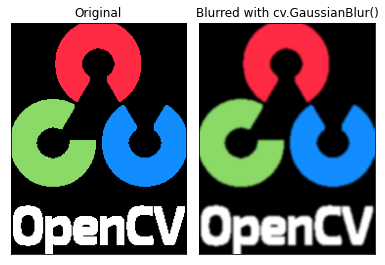

In [6]:
# Blur the image with a 5x5 Gaussian kernel, with the standard
# deviations sigmaX and signaY calculated from the kernel size.
blur = cv.GaussianBlur(img, (5,5), 0)

# Plot the original image and the blurred image.
plt.figure(figsize=(8,6))
plt.subplot(131),plt.imshow(img[:,:,::-1]),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(blur[:,:,::-1]),plt.title('Blurred with cv.GaussianBlur()')
plt.xticks([]), plt.yticks([])
plt.tight_layout(pad=1.0)
plt.show()

### 3. Median Blurring

Here, the function [cv.medianBlur()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9) takes the median of all the pixels under the kernel area, and the central element is replaced with this median value. This is highly effective against *salt-and-pepper* noise in an image (i.e. pixels of low or high intensities sprinkled throughout the image). Interestingly, in the above filters, the central element is a newly calculated value (which might be a pixel value in the image). But in median blurring, the central element is always replaced by some pixel value in the image. It reduces the noise effectively. Its kernel size should be a positive odd integer.

`cv.medianBlur(src, ksize[, dst]) -> dst`
- `src` is the input image.
- `ksize` is the kernel size (positive, odd integer).

The function returns the blurred image as `dst`.

Let's add ~50% salt and pepper noise to the image and apply median blurring.

<ipython-input-7-f89a8797069a>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  img2[salt_coords] = 255
<ipython-input-7-f89a8797069a>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  img2[peper_coords] = 0


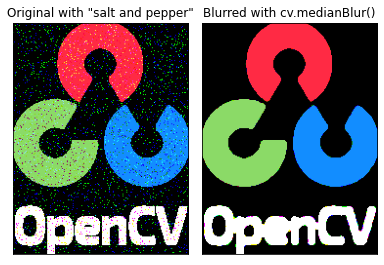

In [7]:
# Add "salt and pepper" noise to the image, i.e. randomly
# set pixels to white (salt) or black (pepper).
img2 = img.copy()
n_pixels = int(np.ceil(0.025 * img2.size))
salt_coords = [np.random.randint(0, i-1, n_pixels) for i in img2.shape]
peper_coords = [np.random.randint(0, i-1, n_pixels) for i in img2.shape]
img2[salt_coords] = 255
img2[peper_coords] = 0

# Blur the image with a 5x5 median kernel.
median = cv.medianBlur(img2, 5)

# Plot the original image and the blurred image.
plt.figure(figsize=(8,6))
plt.subplot(131),plt.imshow(img2[:,:,::-1]),plt.title('Original with "salt and pepper"')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(median[:,:,::-1]),plt.title('Blurred with cv.medianBlur()')
plt.xticks([]), plt.yticks([])
plt.tight_layout(pad=1.0)
plt.show()

### 4.  Bilateral Filtering

The [cv.bilateralFilter()](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed) is highly effective in noise removal while keeping edges sharp. But the operation is slower compared to other filters. We already saw that a Gaussian filter takes the neighbourhood around the pixel and finds its Gaussian weighted average. This Gaussian filter is a function of space alone, that is, nearby pixels are considered while filtering. It doesn't consider whether pixels have almost the same intensity. It doesn't consider whether a pixel is an edge pixel or not. So it blurs the edges also, which we don't want to do.

Bilateral filtering also takes a Gaussian filter in space, but one more Gaussian filter which is a function of pixel difference. The Gaussian function of space makes sure that only nearby pixels are considered for blurring, while the Gaussian function of intensity difference makes sure that only those pixels with similar intensities to the central pixel are considered for blurring. So it preserves the edges since pixels at edges will have large intensity variation.

`cv.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]]) -> dst`
- `src` is the 8-bit or floating-point, 1-channel or 3-channel input image.
- `d` is the diameter of the pixel neighborhood used during filtering (non-positive => it's computed from sigmaSpace).
- `sigmaColor` is the filter sigma (standard deviation) in the color space.
- `sigmaSpace` is the filter sigma (standard deviation) in the coordinate space.
- `borderType` is the typ of padding used for border pixels, e.g. `cv.BORDER_CONSTANT`.

The function returns the filtered image as `dst`.

See [this link](http://people.csail.mit.edu/sparis/bf_course) for more on bilateral filtering.

Let's apply bilateral filtering to a new image with distinguished lines (notice, after applying bilateral filtering, the texture on the surface is gone, but the edges are still preserved).

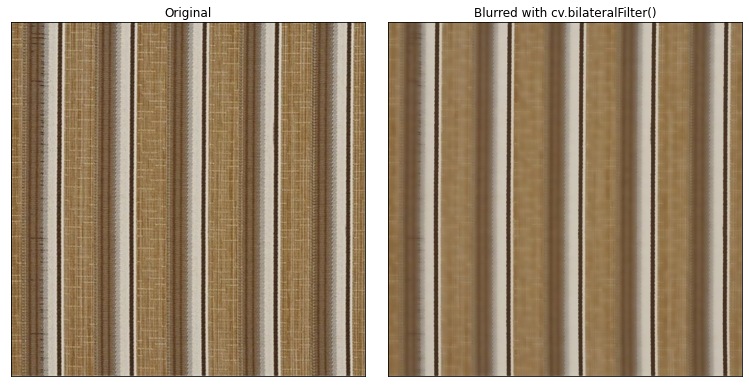

In [8]:
# Read image
img = cv.imread('../data/bilateral.jpg')

# Blur the image with a 13x13 Gaussian kernel, with the standard
# deviations sigmaColor and sigmaSpace set to 100.
blur = cv.bilateralFilter(img, 13, 100, 100)

# Plot the original image and the blurred image.
plt.figure(figsize=(16,6))
plt.subplot(131),plt.imshow(img[:,:,::-1]),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(blur[:,:,::-1]),plt.title('Blurred with cv.bilateralFilter()')
plt.xticks([]), plt.yticks([])
plt.tight_layout(pad=2.0)
plt.show()

## Image gradients

Image gradients are found by convolving the image with a high-pass filter kernel. It is useful for finding edges in images (since it removes low frequency content from the image). OpenCV provides three main types of gradient (or high-pass) filters: [Sobel](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d), [Scharr](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gaa13106761eedf14798f37aa2d60404c9) and [Laplacian](https://docs.opencv.org/4.5.1/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6).

### 1. Sobel and Scharr Derivatives

The Sobel filter combines Gausssian smoothing with a differentiation operation, so it is more resistant to noise. You can specify the direction of derivatives to be taken, vertical or horizontal (by the arguments, `dx` and `dy` respectively). You can also specify the size of the kernel with the argument `ksize`. If `ksize = -1`, a 3x3 Scharr filter is used which gives better results than a 3x3 Sobel filter.

`cv.Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]]) -> dst`
- `src` is the input image.
- `ddepth` is the output image depth (e.g. `cv.CV_U8` for unit8 or `cv.CV_64F` for float64).
- `dx` is the order of the x derivative.
- `dy` is the order of the y derivative.
- `ksize` is the Sobel kernel size (it must be 1, 3, 5, or 7).
- `scale` is an optional scale factor for the computed derivative (by default, no scaling is applied).
- `delta` is an optional delta value that is added to the results prior to storing them in `dst`.
- `borderType` is the border pixel extrapolation method, e.g. `cv.BORDER_CONSTANT`.

The function returns the filtered images as `dst`.

Most often, the function is called with (`dx = 1`, `dy = 0`, `ksize = 3`) or (`dx = 0`, `dy = 1`, `ksize = 3`) to calculate the first x- or y- image derivative. These two cases, respectively, correspond to the following **Sobel kernels**:

$$
kernel =

\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}

\quad \& \quad

kernel =

\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

`cv.Scharr(src, ddepth, dx, dy[, dst[, scale[, delta[, borderType]]]]) -> dst`
- Uses the same input arguments as `cv.Sobel()` above, except for the `ksize` argument, which is always `cv.FILTER_SCHARR` (with a value of -1) and results in the following **Scharr kernels** if `dx=1, dy=0` and `dx=0, dy=1` respectively:

$$
kernel =

\begin{bmatrix}
-3 & 0 & 3 \\
-10 & 0 & 10 \\
-3 & 0 & 3
\end{bmatrix}

\quad \& \quad

\begin{bmatrix}
-3 & -10 & -3 \\
0 & 0 & 0 \\
3 & 10 & 3
\end{bmatrix}
$$

Another commonly used gradient-based operator is the [Prewitt operator](https://en.wikipedia.org/wiki/Prewitt_operator). There is no OpenCV function for this, but the Prewitt kernel can be applied using the `cv.filter2D()` function. For a 3x3 filter, the **Prewitt kernels** in the x- and y directions are as follows:

$$
kernel =

\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}

\quad \& \quad

\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

### 2. Laplacian Derivatives

The Laplacian filter calculates the Laplacian of the image given by the relation, $\Delta src = \frac{\partial^2 src}{\partial x^2} + \frac{\partial^2 src}{\partial y^2}$ where each derivative is found using Sobel derivatives. The Laplacian kernel filters the image in both the x and y directions simultaneously.

`cv.Laplacian(src, ddepth[, dst[, ksize[, scale[, delta[, borderType]]]]]) -> dst`
- The function uses the same input arguments as `cv.Sobel()`, except for the `dx` and `dy` arguments, which are always `dx = 2` and `dy = 2` (i.e. second order derivatives), resulting in the following **Lapacian kernel** if `ksize = 1`:

$$
kernel =

\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

Let's apply the filters to an image and plot the results.

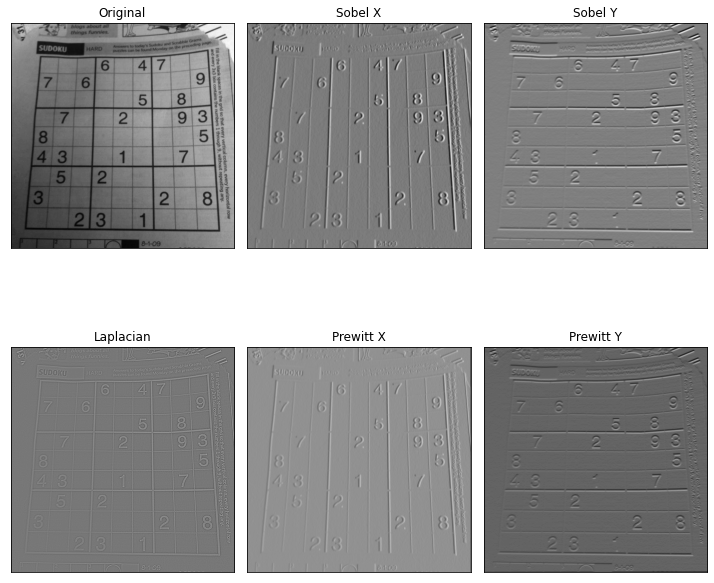

In [9]:
# Read in image as grayscale
img = cv.imread('../data/sudoku.png', 0)

# Apply Laplacian filtering with a 64-bit float as depth.
laplacian = cv.Laplacian(img, cv.CV_64F)

# Apply Sobel filtering with a 64-bit float as depth and a 5x5 kernel.
# The first Sobel filter has dx=1, dy=0 (first order x devivate, no y derivative), i.e. finds vertical lines.
# The second Sobel filter has dx=0, dy=1 (no x derivative, first order y devivate), i.e. finds horizontal lines.
sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)

# Apply Prewitt filtering with a 64-bit float as depth and a 3x3 kernel.
# Here we design the Prewitt kernel manually, and apply the kernel with 'cv.filter2D()'.
# The first Prewitt filter looks for horizontal gradient changes, i.e. finds vertical lines.
# The first Prewitt filter looks for vertical gradient changes, i.e. finds horizontal lines.
prewitt_kernel_x = np.tile([-1, 0, 1], (3,1)).astype(np.float64)
prewitt_kernel_y = np.tile([[-1],[0],[1]], (1,3)).astype(np.float64)
prewittx = cv.filter2D(img, cv.CV_64F, prewitt_kernel_x, borderType=cv.BORDER_CONSTANT)
prewitty = cv.filter2D(img, cv.CV_64F, prewitt_kernel_y, borderType=cv.BORDER_CONSTANT)

# Plot the original image together with the filtered images
plt.figure(figsize=(10,10))
plt.subplot(2,3,1), plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,4), plt.imshow(laplacian, cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,2), plt.imshow(sobelx, cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,3), plt.imshow(sobely, cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,5), plt.imshow(prewittx, cmap = 'gray')
plt.title('Prewitt X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,6), plt.imshow(prewitty, cmap = 'gray')
plt.title('Prewitt Y'), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

### One Important Matter!

In our last example, the output datatype is `cv.CV_64F` (or `np.float64`). What would have happened if we had used  `cv.CV_8U` (or `np.uint8`) instead? There is a problem with this. A black-to-white transition is taken as a positive slope/first derivative (it has a positive value) while a white-to-black transition is taken as a negative slope/first derivative (it has a negative value). So when you convert the image to the  `np.uint8` (unsigned 8-bit integer) datatype, all negative slopes are clipped to zero, i.e. you will miss those edges. As an example, black-to-white transition might result in a value of 255.0, whereas a white-to-black transition might result in a value of -255.0. If we convert these float values to 8-bit unsigned intergers, we would get 255.0 => 255 and -255.0 => 0.

If you want to detect both edges, a better option is to return the output image as a signed datatype with a lot more bits, e.g. `cv.CV_64F` (64-bit signed float), then take its absolute value and finally convert it back to `cv.CV_8U` (unsigned 8-bit integer). Then the values in the example above would be converted as follows:

1. abs(255.0) => 255.0 and abs(-255.0) => 255.0
2. uint8(255.0) => 255 and uint8(255.0) => 255

Let's see how this works in the code below for a horizontal Sobel filter (i.e. that detects vertical lines). Notice that the second edge (right edge) is missed using the first approach, whereas both edges (the left edge and right edge) are detected using the second approach.

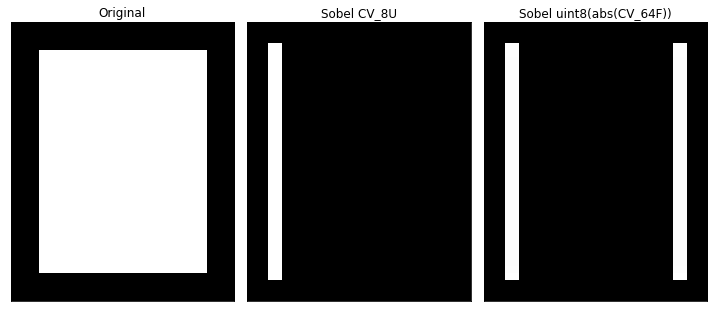

In [10]:
# Let's create a fake grayscale image with
# a centered white box on a black background.
img = np.ones((32,24), dtype=np.uint8) * 255
img = np.pad(img, (4,), 'constant', constant_values=(0,))

# Output dtype = cv.CV_8U
sobelx8u = cv.Sobel(img, cv.CV_8U, 1, 0, ksize=3)

# Output dtype = cv.CV_64F.
# Then take its absolute value and convert it to cv.CV_8U (np.unit8).
sobelx64f = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

# Plot the original image and the filtered images.
plt.figure(figsize=(10,10))
plt.subplot(1,3,1), plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2), plt.imshow(sobelx8u, cmap = 'gray')
plt.title('Sobel CV_8U'), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3), plt.imshow(sobel_8u, cmap = 'gray')
plt.title('Sobel uint8(abs(CV_64F))'), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

## Filtering in the frequency domain

### The Fourier Transform

<p>

<img width="600" height="450" src="../notebook_images/sine_with_fft.png" style="padding: 1px; float: right;">

The Fourier Transform is used to analyze the frequency characteristics of various filters. A 2D Discrete Fourier Transform (DFT) is used to find the frequency content of an image. A fast algorithm called the Fast Fourier Transform (FFT) is used to calculate the DFT. Details about these transforms can be found in any image processing or signal processing textbook.

For a sinusoidal signal, $x(t) = Asin(2\pi ft)$, we can say that $f$ represents the frequency of the signal, and if its frequency content is analyzed we would see a spike at the frequency $f$. For example, in figure to the right, the the top left image shows a sine wave, in the time domain, with a frequency of 4 kHz. Therefore, if we Fourier Transform the signal to the frequency domain, as in the top right image, we see a spike at a the frequency 4 kHz.

If the signal is sampled to form a discrete signal, we get the same frequency content, but the signal is periodic in the range $[−\pi,\pi]$ or $[0,2\pi]$ (or $[0,N]$ for a N-point DFT). You can consider an image as a signal that is sampled in two directions, X and Y. So taking the Fourier Transform in both the X and Y directions, gives us the frequency representation of an image.

More intuitively, for a sinusoidal signal, if the amplitude varies quickly within a short timespan, we would call this a high frequency signal. If it varies slowly, we call it a low frequency signal.
</p>

<p>

<img width="600" height="200" src="../notebook_images/image_and_fft.jpg" style="padding: 1px; float: right;">

The same idea can be extended to images. The *amplitude* (pixel intesity) varies quickly at edge points, or noise points, since we have a sudden change in intensity, e.g. from white to black. So edges and noise points are high frequency content in images. If there are no sudden changes in *amplitude* (pixel intensities), this constitutes low frequency components in images. In the figure to the right, the image has been Fourier Transformed to the frequency domain. In the freuquency domain, the plot has been centered so that the lowest frequency (compare with a DC voltage signal) is in the center of the plot, and frequencies increase radially the further out you get from the center.

For this image, the centered frequency plot is bright in the middle and gets darker radially, the further you get from the center (so there is a lot of low frequency components in the image). In the frequency plot shown in the second image from the left, the center frequencies have been masked out (a black circle indicates that we have set these frequencies to 0). We have essentially applied a high pass filter (since we supress low frequency content). The result of Inverse Fourier Transforming the modified frequency domain back to the time domain is shown in the middle image. Here we see the effect of only keeping high frequency content. Since edges (and noise) constitute high frequency content in an image, we have effectively created an edge detector. If we instead enhance the low frequency content, as seen in the second image from the right (now the center is masked with high values, since the circle is white), we see a blurring effect in the corresponding rightmost image (since we have effectively applied a low pass filter, supressing higher frequencies).
</p>

### Using the Fourier Transform with Numpy

First we will see how to use the Fourier Transform with Numpy. Numpy has an FFT package to do this. The function [np.fft.fft2()](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html) applies the Fourier Transform from the time domain to the frequency domain (which will be an array with complex numbers).

`np.fft.fft2(a, s=None, axes=(-2, -1), norm=None) -> out`
- `a` is the input image (a grayscale image).
- `s` is optional and decides the size of output array (default=`None`, which is the same size as `a`).
- `axes` is optional and determines the axes over which to compute the FFT (default=`(-2,-1)`).
- `norm` is optional and determines the normalization mode (default=`None`, i.e. `backward`).

The Fourier Transformed image is retured in `out`.

The returned array `out` will contain the zero frequency component (DC component) at the top left corner. If you want to center it, you need to shift the result by N2 in both the directions. This can be done with the function [np.fft.fftshift()](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html).

`np.fft.fftshift(x, axes=None) -> y`
- `x` is the input array.
- `axes` is optional an determines the axes to shift (default=`None`, i.e. shifts all axes).

The centered array is returned in `y`.

Once the Fourier Transformed image has been centered, you can calcuate the magnitude spectrum as:

`magnitude_spectrum = 20 * np.log(np.abs(fshift))`, where `fshift` is the centered array.

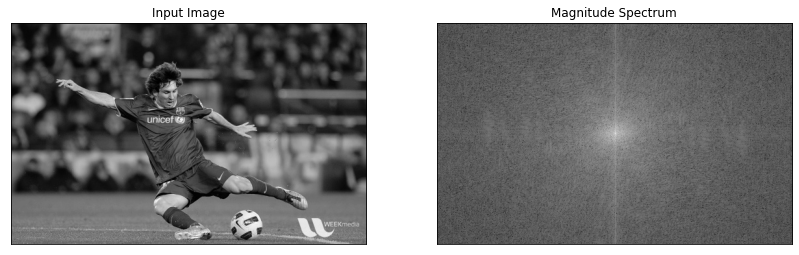

In [11]:
# Read an image as grayscale
img = cv.imread('../data/messi5.jpg', 0)

# Apply FFT to image
dft = np.fft.fft2(img)

# Center the frequency array
dft_shift = np.fft.fftshift(dft)

# Calculate the magnitude spectum
magnitude_spectrum = 20 * np.log(np.abs(dft_shift))

# Plot the imput image and its corresponding magnitude spectrum
plt.figure(figsize=(14,8))
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

As shown in the magnitude spectrum plot, there seems to be a lot of low frequency content (bright white center color).

We can now filter the image in the frequency domain, e.g. like applying a high pass filter, and the reconstruct the image, i.e. inverse Fourier Transform it. High pass filtering entails removing the low frequencies, which can be done by masking the frequency content with a rectangular window, where a center square of this mask is set to 0, and all other values to 1. Then we apply an inverse shift using `np.fft.ifftshift()` which will remove the centering of the frequency content (i.e. so that the DC component again resides at the top left corner). Finally, we inverse Fourier Transform the image from the frequency domain back to the time domain using the `np.ifft2()` function. The result will, once again, be an array of complex numbers, so use the function `np.real()` to only keep the real part.

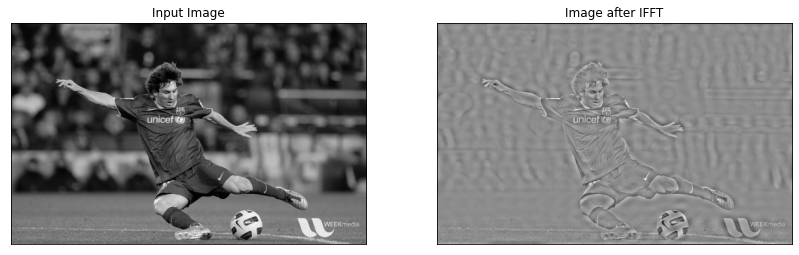

In [12]:
rows, cols = img.shape
crow, ccol = rows//2 , cols//2

# Create a mask of alll ones,
# except for a square in the middle set to 0.
# This essentially zeros out all low frequency
# components, keeping only high frequency components.
mask = np.ones((rows, cols), np.uint8)
mask[crow-20:crow+21, ccol-20:ccol+21] = 0

# Apply mask to frequency content,
# and inverse FFT back to the time domain.
fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)

# Plot the input image and the filtered image.
plt.figure(figsize=(14,8))
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(img_back, cmap = 'gray')
plt.title('Image after IFFT'), plt.xticks([]), plt.yticks([])

plt.show()

The result shows that High Pass Filtering is an edge detection operation. This is exactly what we have seen before with  Image Gradients. This also shows that most of the image data is present in the Low frequency region of the spectrum. 

Notice that there are some artifacts in the image (ripple like structures). This is called *ringing effects*, and is caused by the rectangular window we used for masking. The rectangular mask gets converted to a [sinc](https://en.wikipedia.org/wiki/Sinc_filter#:~:text=In%20signal%20processing%2C%20a%20sinc,response%20is%20a%20rectangular%20function.) shape in the time domain, which causes the problem. A better option would be to use Gaussian Windows.

### Using the Fourier Transform with OpenCV

OpenCV provides the functions `cv.dft()` and `cv.idft()` for transforming between the time- and frequency domain. It returns the same result as the numpy functions, but with two channels, i.e. if the return value from the numpy functions is (x,y), the return value from OpenCV's functions will be (x,y,2). The first channel will contain the real part of the result, and the second channel will contain the imaginary part. The input image should be converted to `np.float32` before using OpenCv's functions.

Let's repeat what we did above, using OpenCV's functions instead.

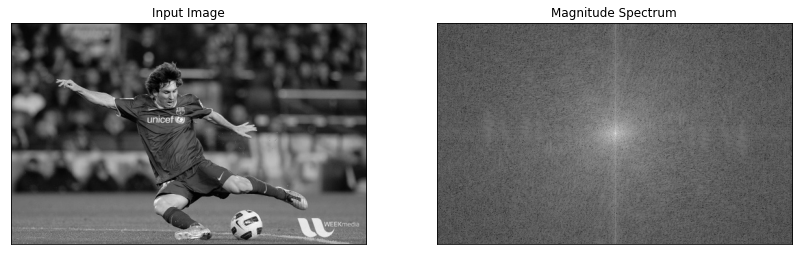

In [13]:
# Read an image as grayscale
img = cv.imread('../data/messi5.jpg', 0)

# Apply FFT to image
dft = cv.dft(np.float32(img), flags = cv.DFT_COMPLEX_OUTPUT)

# Center the frequency array
dft_shift = np.fft.fftshift(dft)

# Calculate the magnitude spectum
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))

# Plot the imput image and its corresponding magnitude spectrum
plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

You can also use the OpenCV function `cv.cartToPolar()`that returns both the magnitude and phase in one function call.

Now we can repeat the filtering and inverse Fourier Transform using OpenCV's functions, but let's apply a low pass filter this time instead, i.e. we create and apply a rectangular mask as before, but this time the square area in the middle of the mask is set to the value 1, and all other values to 0. In other words, we are letting low frequency components keep their values, but zeroing out all high frequency components. This will blur the image in the time domain.

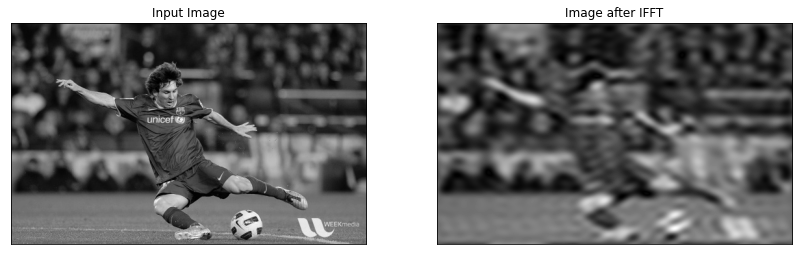

In [14]:
rows, cols = img.shape
crow,ccol = rows//2 , cols//2

# Create a mask of all zeros,
# except for a square in the middle set to 1.
# This essentially zeros out all high frequency
# components, keeping only low frequency components.
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow-20:crow+21, ccol-20:ccol+21] = 1

# Apply mask to frequency content,
# and inverse FFT back to the time domain.
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

# Plot the input image and the filtered image.
plt.figure(figsize=(14,8))
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(img_back, cmap = 'gray')
plt.title('Image after IFFT'), plt.xticks([]), plt.yticks([])

plt.show()

### Performance Optimization of DFT

The Fourier Transform is fastest if the input array size is a power of two. Therefore the input array can be zero padded before appling the Fourier Transform in order to speed things up, and we already know how to zero pad an array. To determine the optimal shape of an array before using it with the functions `cv.dft()`or `np.fft.fft2()`, OpenCV provides the function `cv.getOptimalDFTSize()`.

Let's look at a simple example of how to use the function.

In [15]:
# Read in an image as grayscale
img = cv.imread('../data/messi5.jpg', 0)

# The image has the following shape
n_rows, n_cols = img.shape

print(f"n_rows: {n_rows}")
print(f"n_cols: {n_cols}")

# Now, let's find the optimal shape for the FFT functions
optimal_n_rows = cv.getOptimalDFTSize(rows)
optimal_n_cols = cv.getOptimalDFTSize(cols)

print(f"optimal_n_rows: {optimal_n_rows}")
print(f"optimal_n_cols: {optimal_n_cols}")

n_rows: 342
n_cols: 548
optimal_n_rows: 360
optimal_n_cols: 576


### Frequency Spectrum of Common Filters

Let's plot the frequency spectrum of some common filters (kernels) we have looked at, to see what frequencies they filter. 
- Our smoothing filters (low pass filters) should have high values (white) near the center of the 2D frequency spectrum.
- Our gradient filters (high pass filters) should have low values (black) near the center of the 2D frequency spectrum.

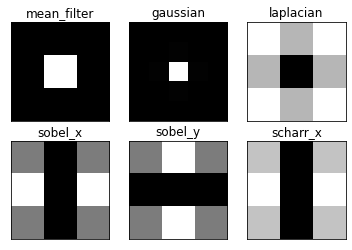

In [16]:
###################################################
# Smoothing (blurring) kernels (low pass filters) #
###################################################

# Simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# Gaussian filter
x = cv.getGaussianKernel(5, 10)
gaussian = x*x.T

#########################################################
# Gradient (edge detecting) kernels (high pass filters) #
#########################################################

# Scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])

# Sobel in x direction
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

# Sobel in y direction
sobel_y = np.array([[-1,-2,-1],
                    [0, 0, 0],
                    [1, 2, 1]])

# Laplacian
laplacian = np.array([[0, 1, 0],
                     [1,-4, 1],
                     [0, 1, 0]])

# Fourier Transform the filters and plot their magnitude spectrum
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', 'sobel_y', 'scharr_x']

fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

for i in range(6):
    plt.subplot(2,3,i+1), plt.imshow(mag_spectrum[i], cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()